# Tuto: convolve template to spike

author: steeve.laquitaine@epfl.ch

## Setup

Virtual env is `env_kilosort_silico`

You should have extracted the templates from a KS3 run by running `python3.9 -m src.pipes.postpro.univ_temp` in the terminal before. See usage in `univ_temp` module.

The dot product `W^T.D` provides the scaling amplitude of the best fitted template.

In [27]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from spikeinterface.comparison import GroundTruthStudy
from IPython.display import Image
from scipy.signal import correlate
from scipy.signal import correlation_lags
from IPython.display import Image

# SET DIMENSIONALITY REDUCTION tools
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.dataeng.deepnet.dataeng import get_instances
from src.nodes.dataeng.silico import probe_wiring
from src.nodes.dataeng.silico.filtering import filter_microcircuit_cells
from src.nodes.prepro import preprocess
from src.nodes.truth.silico import ground_truth
from src.nodes.io.silico.loading import load_campaign_params
from src.pipes.postpro import waveform, univ_temp
from src.nodes import viz

# SET DATA PATH 
# whole campaign files
SPIKE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/spiketrains.pkl'
RAW_LFP_TRACE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/traces.pkl'
CELL_TRACE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/cells/cell_3754013_trace.pkl'


# SET PARAMETERS
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_02_19"
STUDY_FOLDER = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/sorting/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/study'
EXAMPLE_CELL_ID = 4209594
EXAMPLE_CHANNEL_ID = 20
MS_BEFORE = 3           # ms
MS_AFTER = 3            # ms
CELL_TYPE = "PYR"
LOAD_WAVEFORM_EXTRACTOR = False
LOAD_GROUND_TRUTH = True
LOAD_PREP_TRACE = True


# SET CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()


# SET MODEL INPUT DATA PATHS
INSTANCE_FILE_PATH = data_conf["sorting"]["deepnet"]["input"]["instances"]
CHANNEL_IDS_FILE_PATH = data_conf["sorting"]["deepnet"]["input"]["channel_ids"]
CELL_LABELS_FILE_PATH = data_conf["sorting"]["deepnet"]["input"]["cell_labels"]
SPIKE_STATUS_FILE_PATH = data_conf["sorting"]["deepnet"]["input"]["spike_status"]
NEAREST_CHANNEL_FILE_PATH  = data_conf["sorting"]["deepnet"]["input"]["nearest_channel"]

# SET PLOT PARAMETERS
cmap = plt.get_cmap("tab20")
colors = cmap(np.linspace(0,1,24))[:,:3]

# set colors for detected 
detected_colors = colors[:12,]
missed_colors = colors[12:,]

2023-05-15 12:54:12,694 - root - utils.py - get_config - INFO - Reading experiment config.
2023-05-15 12:54:12,718 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-05-15 12:54:12,727 - root - utils.py - get_config - INFO - Reading experiment config.
2023-05-15 12:54:12,751 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-05-15 12:54:12,766 - root - utils.py - get_config - INFO - Reading experiment config.
2023-05-15 12:54:12,790 - root - utils.py - get_config - INFO - Reading experiment config. - done


1. fix a channel
2. find nearby ground truth cells (within 40 microns of the channel)
3. fit the cell spikes and universal templates with tsne and project on a 2D space
4. get seed templates, missed sparse cells , detected sparse cells  


spike dataset engineering was done with '/gpfs/bbp.cscs.ch/data/project/proj68/home/laquitai/spike-sorting/notebooks/2_deepnet/0b_dataeng_neuropix_32.ipynb'

## Check templates, detected cell spikes

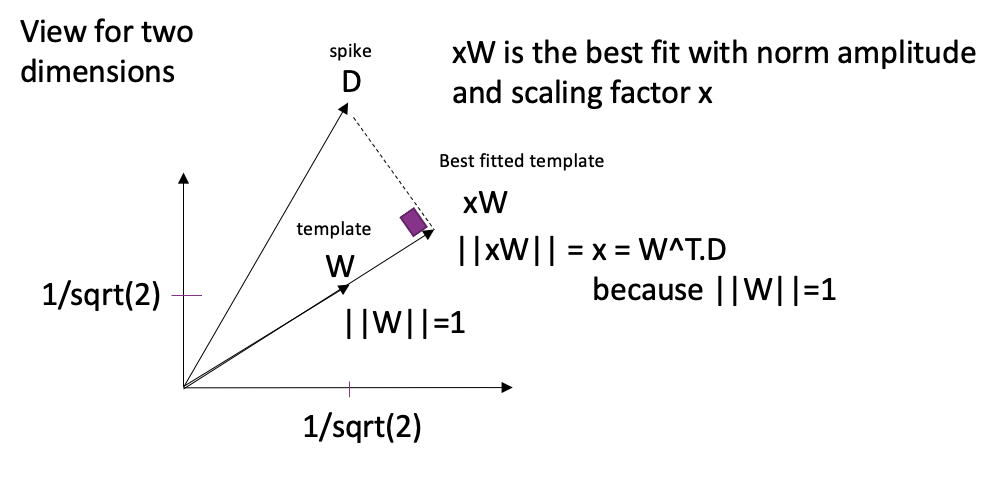

euclidean norm amplitude of D projection on W: 1.5909902576697321
dot product: 1.590990257669732


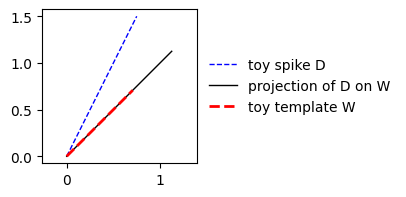

In [3]:
# show how the dot product provide the scaling amplitude of the best fitted template
display(Image(filename="notebooks/1_results/assets/template_fitting.png", width=800))

def show_that_dot_product_is_amplitude_x():

    # create unit norm vector W (toy template)
    W = np.array([1/np.sqrt(2), 1/np.sqrt(2)])

    # create vector D (toy spike)
    D = np.array([0.75, 1.5])

    # finding norm of the vector W
    W_norm = np.sqrt(sum(W**2))	

    # project v on u 
    proj_of_D_on_W = (np.dot(D, W)/W_norm**2)*W

    # plot
    _, axis = plt.subplots(1,1, figsize=(2,2))
    axis.plot([0, D[0]],[0, D[1]], "b--", linewidth=1, label="toy spike D");
    axis.plot([0, proj_of_D_on_W[0]],[0, proj_of_D_on_W[1]], "k", linewidth=1, label="projection of D on W");
    axis.plot([0, W[0]],[0, W[1]], "r--", linewidth=2, label="toy template W");

    # report
    print("euclidean norm amplitude of D projection on W:", np.sqrt(sum(proj_of_D_on_W**2)))
    print("dot product:", np.dot(D,W))
    axis.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False);
    axis.axis("equal")

show_that_dot_product_is_amplitude_x()

euclidean norm amplitude of W projection on D: 0.9486832980505137
dot product: 1.590990257669732


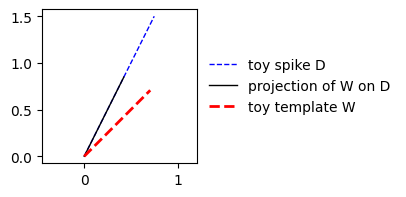

In [4]:
# show how the dot product of W onto D does not provide the scaling amplitude of the best fitted spike to the template
def show_that_dot_product_is_amplitude_x():

    # create unit norm vector W (toy template)
    W = np.array([1/np.sqrt(2), 1/np.sqrt(2)])

    # create vector D (toy spike)
    D = np.array([0.75, 1.5])

    # finding norm of the vector D
    D_norm = np.sqrt(sum(D**2))	

    # project W onto D
    proj_of_W_on_D = (np.dot(W, D)/D_norm**2)*D

    # plot
    _, axis = plt.subplots(1,1, figsize=(2,2))
    axis.plot([0, D[0]],[0, D[1]], "b--", linewidth=1, label="toy spike D");
    axis.plot([0, proj_of_W_on_D[0]],[0, proj_of_W_on_D[1]], "k", linewidth=1, label="projection of W on D");
    axis.plot([0, W[0]],[0, W[1]], "r--", linewidth=2, label="toy template W");
    axis.axis("equal")

    # report
    print("euclidean norm amplitude of W projection on D:", np.sqrt(sum(proj_of_W_on_D**2)))
    print("dot product:", np.dot(W,D))
    axis.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False);

show_that_dot_product_is_amplitude_x()

/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/env_kilosort_silico/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


euclidean norm amplitude of W projection on D: [0.89442719]
dot product: [[0.89442719]]
explained variance: [[0.89442719]]


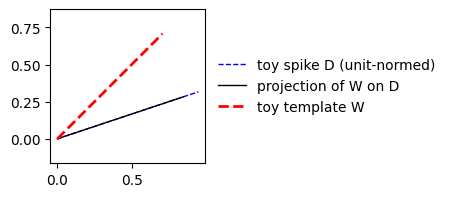

In [38]:
# show how the dot product of W onto D provides the scaling amplitude of the best fitted spike to the template
def show_that_dot_product_is_amplitude_x():

    # create unit norm 2D column (default) vector W (toy template)
    W = np.array([1/np.sqrt(2), 1/np.sqrt(2)]).reshape(2,1)

    # create 2D column (default) vector D (toy spike)
    D = np.array([0.75, 0.25]).reshape(2,1)

    # unit-normalize D
    D_norm = np.sqrt(sum(D**2))	
    D_unit_normed = D / D_norm
    D_norm = np.sqrt(sum(D_unit_normed**2))

    # project W onto D: can use dot product which simply performs matrix multiplication if 
    # the two vectors and 2D or preferably. In that case @ is preferable.
    proj_of_W_on_D = ((np.transpose(W) @ D_unit_normed)/D_norm**2)*D_unit_normed

    # plot
    _, axis = plt.subplots(1,1, figsize=(2,2))
    axis.plot([0, D_unit_normed[0]],[0, D_unit_normed[1]], "b--", linewidth=1, label="toy spike D (unit-normed)");    
    axis.plot([0, proj_of_W_on_D[0]],[0, proj_of_W_on_D[1]], "k", linewidth=1, label="projection of W on D");
    axis.plot([0, W[0]],[0, W[1]], "r--", linewidth=2, label="toy template W");

    # report
    print("euclidean norm amplitude of W projection on D:", np.sqrt(sum(proj_of_W_on_D**2)))
    print("dot product:", np.transpose(W) @ D_unit_normed)
    print("explained variance:", np.transpose(W) @ D_unit_normed)
    axis.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False);
    axis.axis("equal")
    
show_that_dot_product_is_amplitude_x()

explained variance = (W . D)^2 / ||W||^2

where (W . D) is the projection of D onto W

## References

[Refresher 1 on projections](https://sites.science.oregonstate.edu/math/home/programs/undergrad/CalculusQuestStudyGuides/vcalc/dotprod/dotprod.html)

[Refresher 2 on projections](https://www.youtube.com/watch?v=Mxwy9iiQjf0)

[Tibshirani on PCA](https://www.stat.cmu.edu/~ryantibs/datamining/lectures/08-dim2-marked.pdf)

Wij is (4 timepoint rows x 1 channel col)

Dik is (4 timepoint rows x N signal snippets to match)

Scalar product is (Wij^T).Dik = Wji.Dik. It is the projection of W onto D.



In [39]:
import numpy as np

# by default columns vectors or matrices
W = np.array([1,2,3,4]).reshape(4,1)
D = np.array([10,11,12,13,14,15,16,18]).reshape(4,2)

print(W)
print(D)

# np.dot for matrix multiplication (when 2D vectors and matrices)
print(np.dot(np.transpose(W),D))

# preferably
print(np.transpose(W) @ D)

# print(np.dot(D,W))

[[1]
 [2]
 [3]
 [4]]
[[10 11]
 [12 13]
 [14 15]
 [16 18]]
[[140 154]]
[[140 154]]
